# Training YOLO11n-cls on Fruits-360 Dataset

This notebook demonstrates how to train a YOLO11n-cls model for fruit classification using the Fruits-360 dataset.

## 1. Setup Environment
First, let's install the necessary packages and import required libraries.

In [2]:
# Basic data handling and utilities
import os
import numpy as np
import pandas as pd
from pathlib import Path
import random
import shutil
from tqdm.notebook import tqdm

# Image processing
import cv2
from PIL import Image

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and related libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Ultralytics for YOLOv11n-cls
from ultralytics import YOLO

# For reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


Dataset configuration:
  path: ../datasets/fruits_yolo
  train: train
  val: val
  nc: 76
  names: [list of 76 class names]

Dataset statistics:
  Training images: 110856
  Validation images: 27843


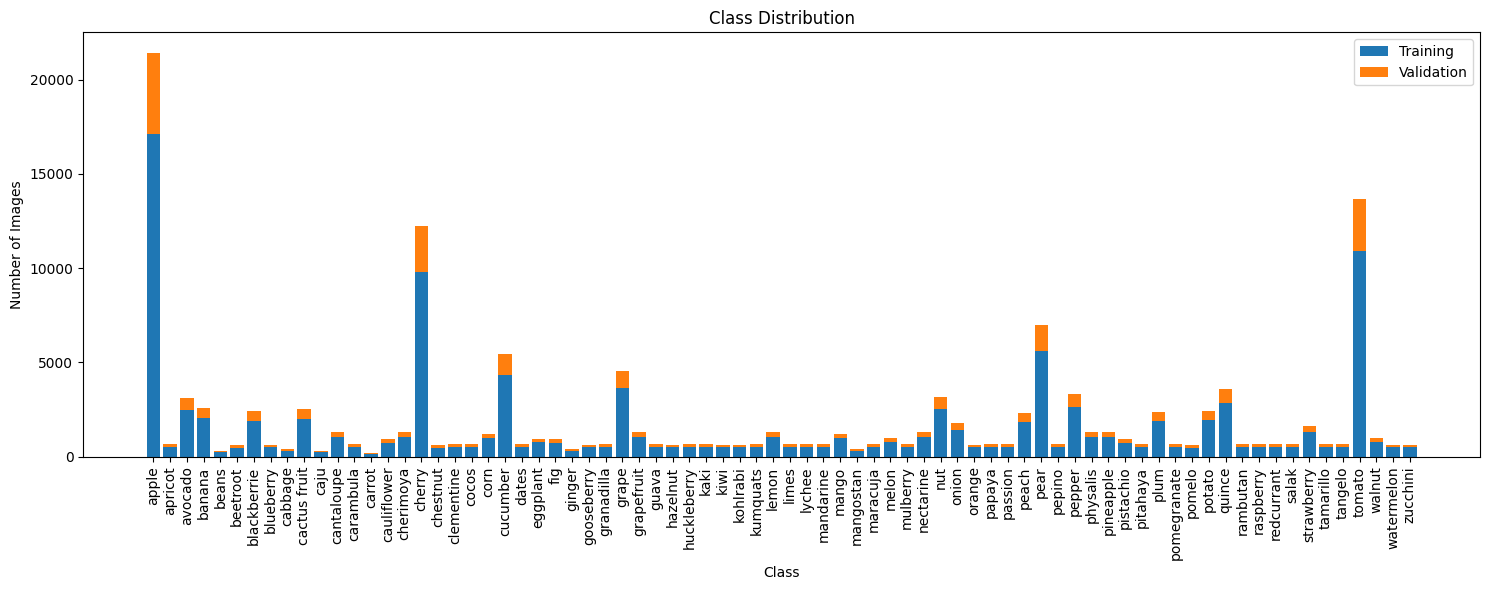


Top 10 classes by number of images:


,Class,Training,Validation,Total
0,apple,17142,4302,21444
72,tomato,10928,2744,13672
16,cherry,9777,2453,12230
53,pear,5604,1409,7013
21,cucumber,4350,1091,5441
28,grape,3648,917,4565
64,quince,2875,721,3596
55,pepper,2641,663,3304
47,nut,2544,640,3184
2,avocado,2473,620,3093


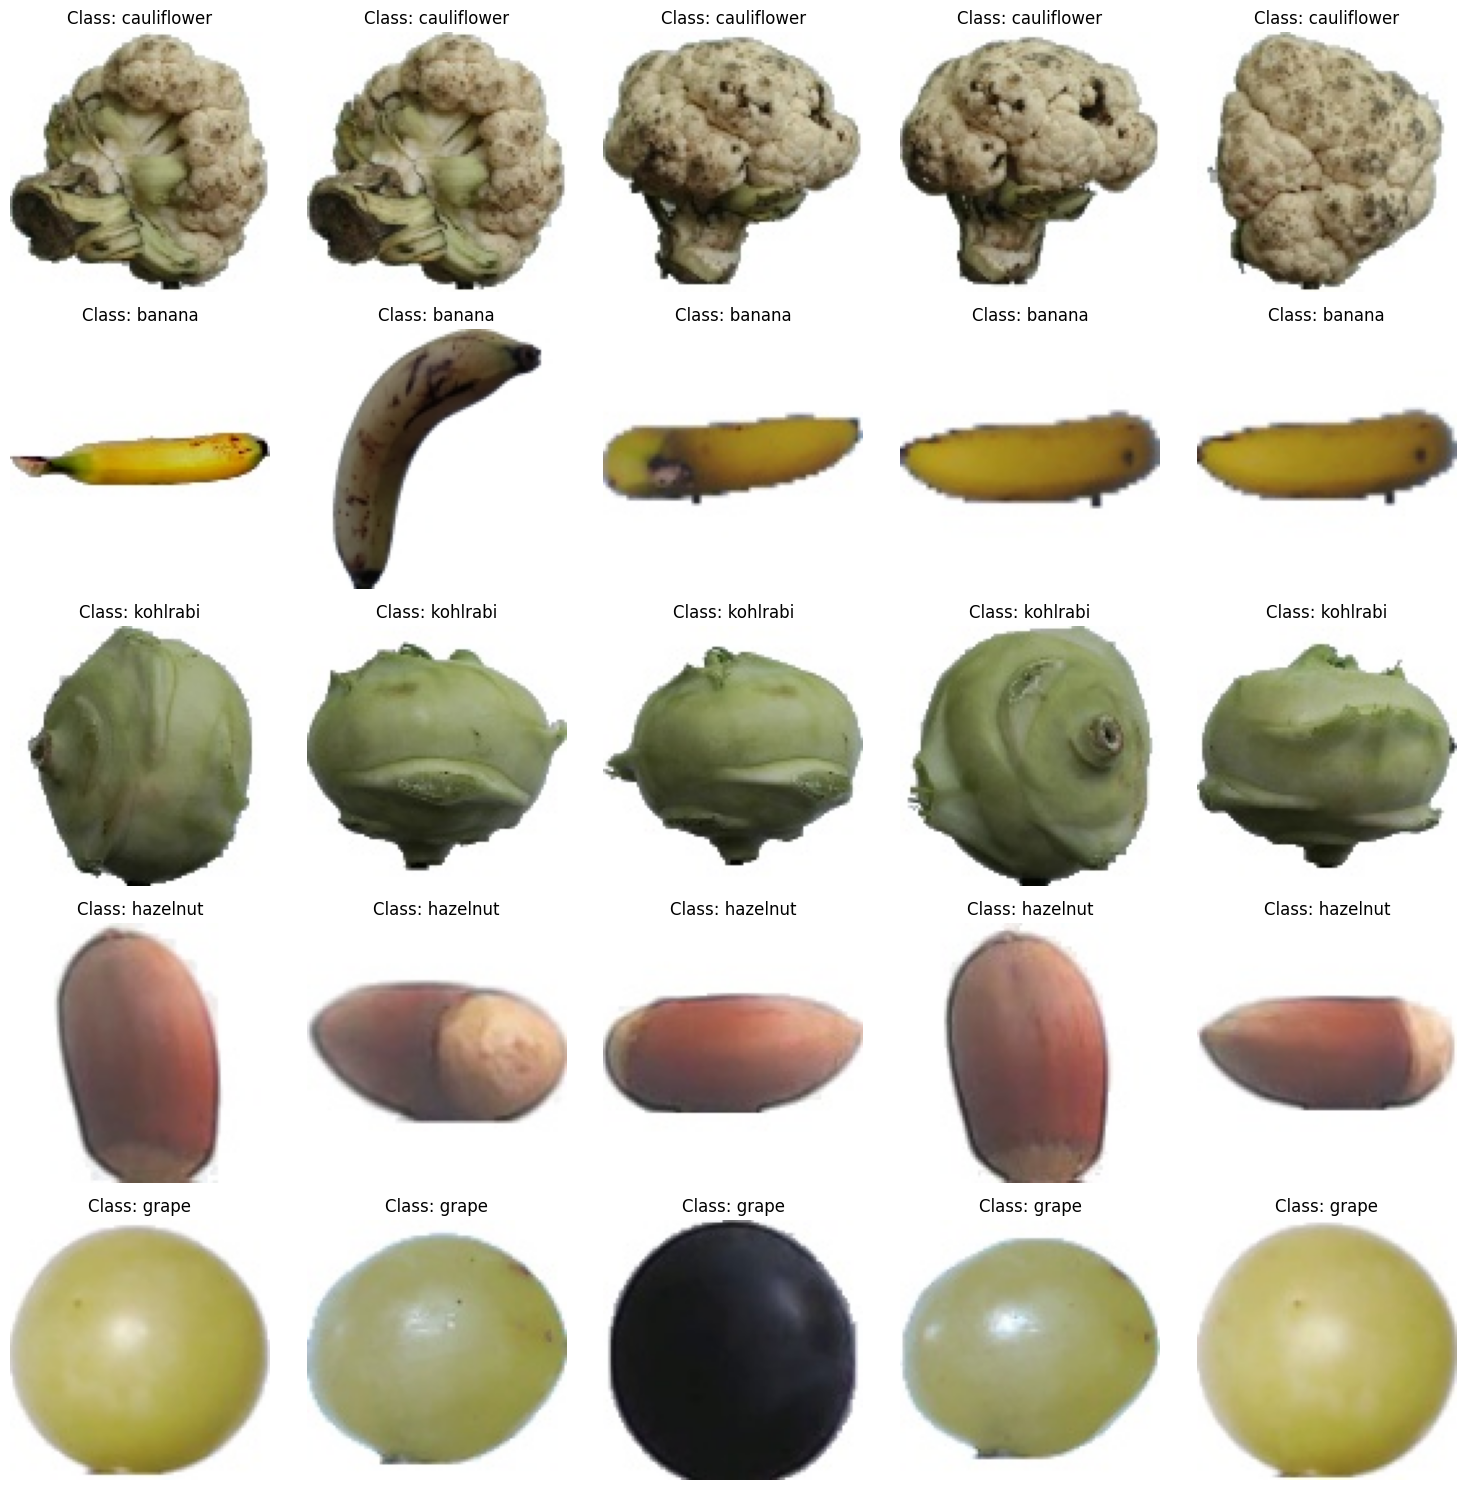


Dataset is ready for YOLO training!
YAML config path: ../datasets/fruits_yolo/data.yaml
Use this path when initializing the YOLO model for training.


In [4]:
# Define path to the prepared dataset
dataset_dir = os.path.join("..", "datasets", "fruits_yolo")

# Check if the dataset exists
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Dataset directory {dataset_dir} not found. Please run dataset_preparation.ipynb first.")

# Load dataset information from data.yaml
import yaml
yaml_path = os.path.join(dataset_dir, "data.yaml")

with open(yaml_path, "r") as f:
    data_config = yaml.safe_load(f)

print("Dataset configuration:")
for key, value in data_config.items():
    if key == 'names':
        print(f"  {key}: [list of {len(value)} class names]")
    else:
        print(f"  {key}: {value}")

# Define paths to the training and validation sets
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")

# Check if we have the expected directory structure
if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    raise FileNotFoundError(f"Expected directory structure not found. Please run dataset_preparation.ipynb first.")

# Class names from YAML
class_names = data_config['names']

# Count images in each class directory
class_counts = {'train': {}, 'val': {}}
total_train = 0
total_val = 0

for cls in class_names:
    train_class_dir = os.path.join(train_dir, cls)
    val_class_dir = os.path.join(val_dir, cls)
    
    if os.path.exists(train_class_dir):
        n_train = len([f for f in os.listdir(train_class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        class_counts['train'][cls] = n_train
        total_train += n_train
    else:
        class_counts['train'][cls] = 0
        
    if os.path.exists(val_class_dir):
        n_val = len([f for f in os.listdir(val_class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        class_counts['val'][cls] = n_val
        total_val += n_val
    else:
        class_counts['val'][cls] = 0

print("\nDataset statistics:")
print(f"  Training images: {total_train}")
print(f"  Validation images: {total_val}")

# Create DataFrame for visualization
df_data = []
for cls in class_names:
    df_data.append({
        'Class': cls,
        'Training': class_counts['train'].get(cls, 0),
        'Validation': class_counts['val'].get(cls, 0),
        'Total': class_counts['train'].get(cls, 0) + class_counts['val'].get(cls, 0)
    })

df = pd.DataFrame(df_data)

# Display class distribution
plt.figure(figsize=(15, 6))
plt.bar(df['Class'], df['Training'], label='Training')
plt.bar(df['Class'], df['Validation'], bottom=df['Training'], label='Validation')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# Display top 10 classes by total count
top_classes = df.sort_values('Total', ascending=False).head(10)
print("\nTop 10 classes by number of images:")
display(top_classes)

# Display a few random examples from different classes
n_classes_to_show = min(5, len(class_names))
sample_classes = random.sample(class_names, n_classes_to_show)

plt.figure(figsize=(15, n_classes_to_show * 3))
for i, cls in enumerate(sample_classes):
    cls_dir = os.path.join(train_dir, cls)
    if not os.path.exists(cls_dir):
        continue
        
    images = [f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    if not images:
        continue
        
    samples = random.sample(images, min(5, len(images)))
    
    for j, img_file in enumerate(samples):
        img_path = os.path.join(cls_dir, img_file)
        img = Image.open(img_path)
        
        plt.subplot(n_classes_to_show, 5, i*5 + j + 1)
        plt.imshow(img)
        plt.title(f"Class: {cls}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Confirm the dataset is ready for YOLO training
print("\nDataset is ready for YOLO training!")
print(f"YAML config path: {yaml_path}")
print("Use this path when initializing the YOLO model for training.")

In [ ]:
# Set training parameters
# For RTX 4050 (6GB VRAM), we'll use a moderate batch size to avoid OOM errors
BATCH_SIZE = 16      # Start with a conservative batch size
EPOCHS = 25          # Number of training epochs
IMG_SIZE = 224       # Image resolution for training
MODEL_NAME = "yolo11n-cls.pt"  # Pre-trained YOLOv11n classification model

# Configure training settings for YOLO classification
train_args = {
    # "data": yaml_path,             # Path to data.yaml file
    "data": dataset_dir,             # Path to data.yaml file
    "epochs": EPOCHS,              # Number of epochs
    "imgsz": IMG_SIZE,             # Image size
    "batch": BATCH_SIZE,           # Batch size
    "device": 0,                   # Use GPU (0)
    "workers": 4,                  # Number of worker threads for data loading
    "optimizer": "AdamW",          # Optimizer
    "lr0": 0.001,                  # Initial learning rate
    "patience": 5,                 # Early stopping patience
    "project": "../runs",          # Project directory
    "name": "fruits_classification",# Experiment name
    "exist_ok": True,              # Overwrite existing experiment
    "pretrained": True,            # Use pretrained weights
    "dropout": 0.1,                # Dropout rate
    "seed": 42,                    # Random seed for reproducibility
    "cache": True,                 # Cache images for faster training
}

print(f"Starting training with batch size {BATCH_SIZE} and image size {IMG_SIZE}...")

# Load the model
model = YOLO(MODEL_NAME)

# Train the model
# results = model.train(**train_args)

# Display training summary
print("\nTraining completed!")
print(f"Results saved to {os.path.join('../runs', 'fruits_classification')}")

Starting training with batch size 16 and image size 224...
New https://pypi.org/project/ultralytics/8.3.159 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.158 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5771MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../datasets/fruits_yolo, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.

train: Scanning /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_yolo/train... 110856 images, 0 corrupt: 100%|██████████| 110856/110856 [00:11<00:00, 9831.60it/s] 



train: New cache created: /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_yolo/train.cache
WARNING ⚠️ Classification `cache_ram` training has known memory leak in https://github.com/ultralytics/ultralytics/issues/9824, setting `cache_ram=False`.
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 53.4±20.9 MB/s, size: 7.3 KB)
WARNING ⚠️ Classification `cache_ram` training has known memory leak in https://github.com/ultralytics/ultralytics/issues/9824, setting `cache_ram=False`.
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 53.4±20.9 MB/s, size: 7.3 KB)


val: Scanning /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_yolo/val... 27843 images, 0 corrupt: 100%|██████████| 27843/27843 [00:02<00:00, 9760.05it/s] 



val: New cache created: /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_yolo/val.cache
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 4 dataloader workers
Logging results to ../runs/fruits_classification
Starting training for 25 epochs...

      Epoch    GPU_mem       loss  Instances       Size
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 4 dataloader workers
Logging results to ../runs/fruits_classification
Starting training for 25 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 871/871 [00:13<00:00, 66.16it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 871/871 [00:12<00:00, 68.96it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 871/871 [00:12<00:00, 68.86it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 871/871 [00:12<00:00, 67.01it/s]



                   all          1          1

      Epoch    GPU_mem       loss  Instances       Size

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 871/871 [00:11<00:00, 74.66it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 871/871 [00:11<00:00, 72.85it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 871/871 [00:11<00:00, 74.40it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 871/871 [00:11<00:00, 74.16it/s]

                   all          1          1
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



8 epochs completed in 0.370 hours.
Optimizer stripped from ../runs/fruits_classification/weights/last.pt, 3.4MB
Optimizer stripped from ../runs/fruits_classification/weights/last.pt, 3.4MB
Optimizer stripped from ../runs/fruits_classification/weights/best.pt, 3.4MB

Validating ../runs/fruits_classification/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5771MiB)
Optimizer stripped from ../runs/fruits_classification/weights/best.pt, 3.4MB

Validating ../runs/fruits_classification/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5771MiB)
YOLO11n-cls summary (fused): 47 layers, 1,623,380 parameters, 0 gradients, 3.2 GFLOPs
YOLO11n-cls summary (fused): 47 layers, 1,623,380 parameters, 0 gradients, 3.2 GFLOPs
train: /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_yolo/train... found 110856 images in 76 classes ✅ 
train: /home/kuba/Coding/Uczelni

               classes   top1_acc   top5_acc: 100%|██████████| 871/871 [00:11<00:00, 73.30it/s]



                   all          1          1
Speed: 0.1ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to ../runs/fruits_classification
Speed: 0.1ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to ../runs/fruits_classification

Training completed!
Results saved to ../runs/fruits_classification

Training completed!
Results saved to ../runs/fruits_classification


## 3. Evaluate Model Performance

Now let's evaluate the trained model's performance and visualize the results.

Ultralytics 8.3.158 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5771MiB)
YOLO11n-cls summary (fused): 47 layers, 1,623,380 parameters, 0 gradients, 3.2 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 42.0±25.4 MB/s, size: 7.3 KB)


val: Scanning /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_yolo/val... 27843 images, 0 corrupt: 100%|██████████| 27843/27843 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1741/1741 [00:12<00:00, 137.45it/s]


                   all          1          1
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/kuba/Coding/Uczelnia/fridge_project/runs/classify/val2
Validation results:
  Accuracy: 100.00%
  Top-5 Accuracy: 100.00%
Could not load training metrics: '                  epoch'


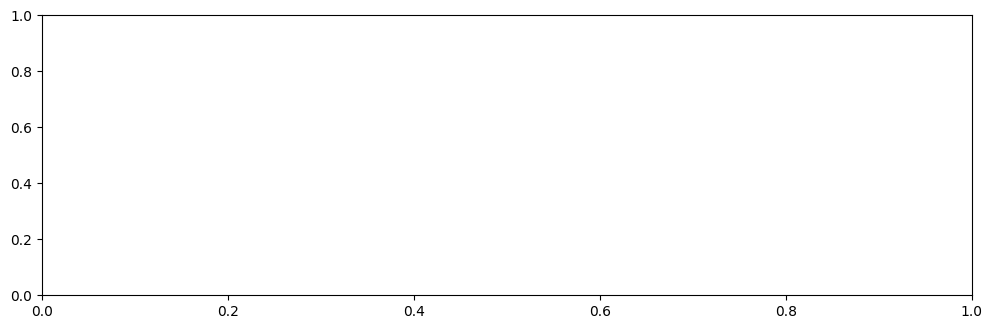

In [6]:
# Load the best trained model
best_model_path = os.path.join('../runs', 'fruits_classification', 'weights', 'best.pt')
trained_model = YOLO(best_model_path)

# Fix the data.yaml file before validation
# This will convert the comma-separated string into a proper list format
with open(yaml_path, 'r') as f:
    yaml_data = yaml.safe_load(f)

# Convert the comma-separated string to a proper list
if isinstance(yaml_data['names'], str):
    yaml_data['names'] = [name.strip() for name in yaml_data['names'].split(',')]
    
    # Verify that the length matches nc
    if len(yaml_data['names']) != yaml_data['nc']:
        print(f"Warning: Found {len(yaml_data['names'])} names but nc={yaml_data['nc']}. Updating nc to match.")
        yaml_data['nc'] = len(yaml_data['names'])
    
    # Save the fixed yaml file
    fixed_yaml_path = os.path.join(dataset_dir, "data_fixed.yaml")
    with open(fixed_yaml_path, 'w') as f:
        yaml.dump(yaml_data, f, default_flow_style=False)
    
    print(f"Fixed YAML file saved to {fixed_yaml_path}")
    yaml_path = fixed_yaml_path

# Validate the model on the validation set
val_results = trained_model.val(data=yaml_path)

# Print validation metrics
print(f"Validation results:")
print(f"  Accuracy: {val_results.top1 * 100:.2f}%")  # Top-1 accuracy
print(f"  Top-5 Accuracy: {val_results.top5 * 100:.2f}%")  # Top-5 accuracy

# Make sure to use the same class_names list for the rest of the code
class_names = yaml_data['names']

# Load the training metrics from the results file
import pandas as pd
import matplotlib.pyplot as plt

try:
    metrics_csv = list(Path(os.path.join('../runs', 'fruits_classification')).glob('*.csv'))[0]
    metrics = pd.read_csv(metrics_csv)
    
    # Plot training metrics
    plt.figure(figsize=(12, 8))
    
    # Plot training and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(metrics['                  epoch'], metrics['               train/loss'], label='Training Loss')
    plt.plot(metrics['                  epoch'], metrics['                 val/loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot top-1 and top-5 accuracy
    plt.subplot(2, 1, 2)
    plt.plot(metrics['                  epoch'], metrics['                 metrics/accuracy_top1'], label='Top-1 Accuracy')
    plt.plot(metrics['                  epoch'], metrics['                 metrics/accuracy_top5'], label='Top-5 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not load training metrics: {e}")

## 4. Test the Model on Sample Images

Let's test our trained model on some sample images from the validation set.

image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_yolo/val/chestnut/Chestnut 1_r2_93_100.jpg: 224x224 chestnut 1.00, nut 0.00, nectarine 0.00, pomegranate 0.00, mango 0.00, 3.1ms
Speed: 1.6ms preprocess, 3.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_yolo/val/kaki/Kaki 1_129_100.jpg: 224x224 kaki 1.00, clementine 0.00, pomegranate 0.00, kumquats 0.00, tomato 0.00, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_yolo/val/cauliflower/Cauliflower 1_r_212_100.jpg: 224x224 cauliflower 1.00, ginger 0.00, cherimoya 0.00, pineapple 0.00, apple 0.00, 3.7ms
Speed: 2.7ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_yolo/va

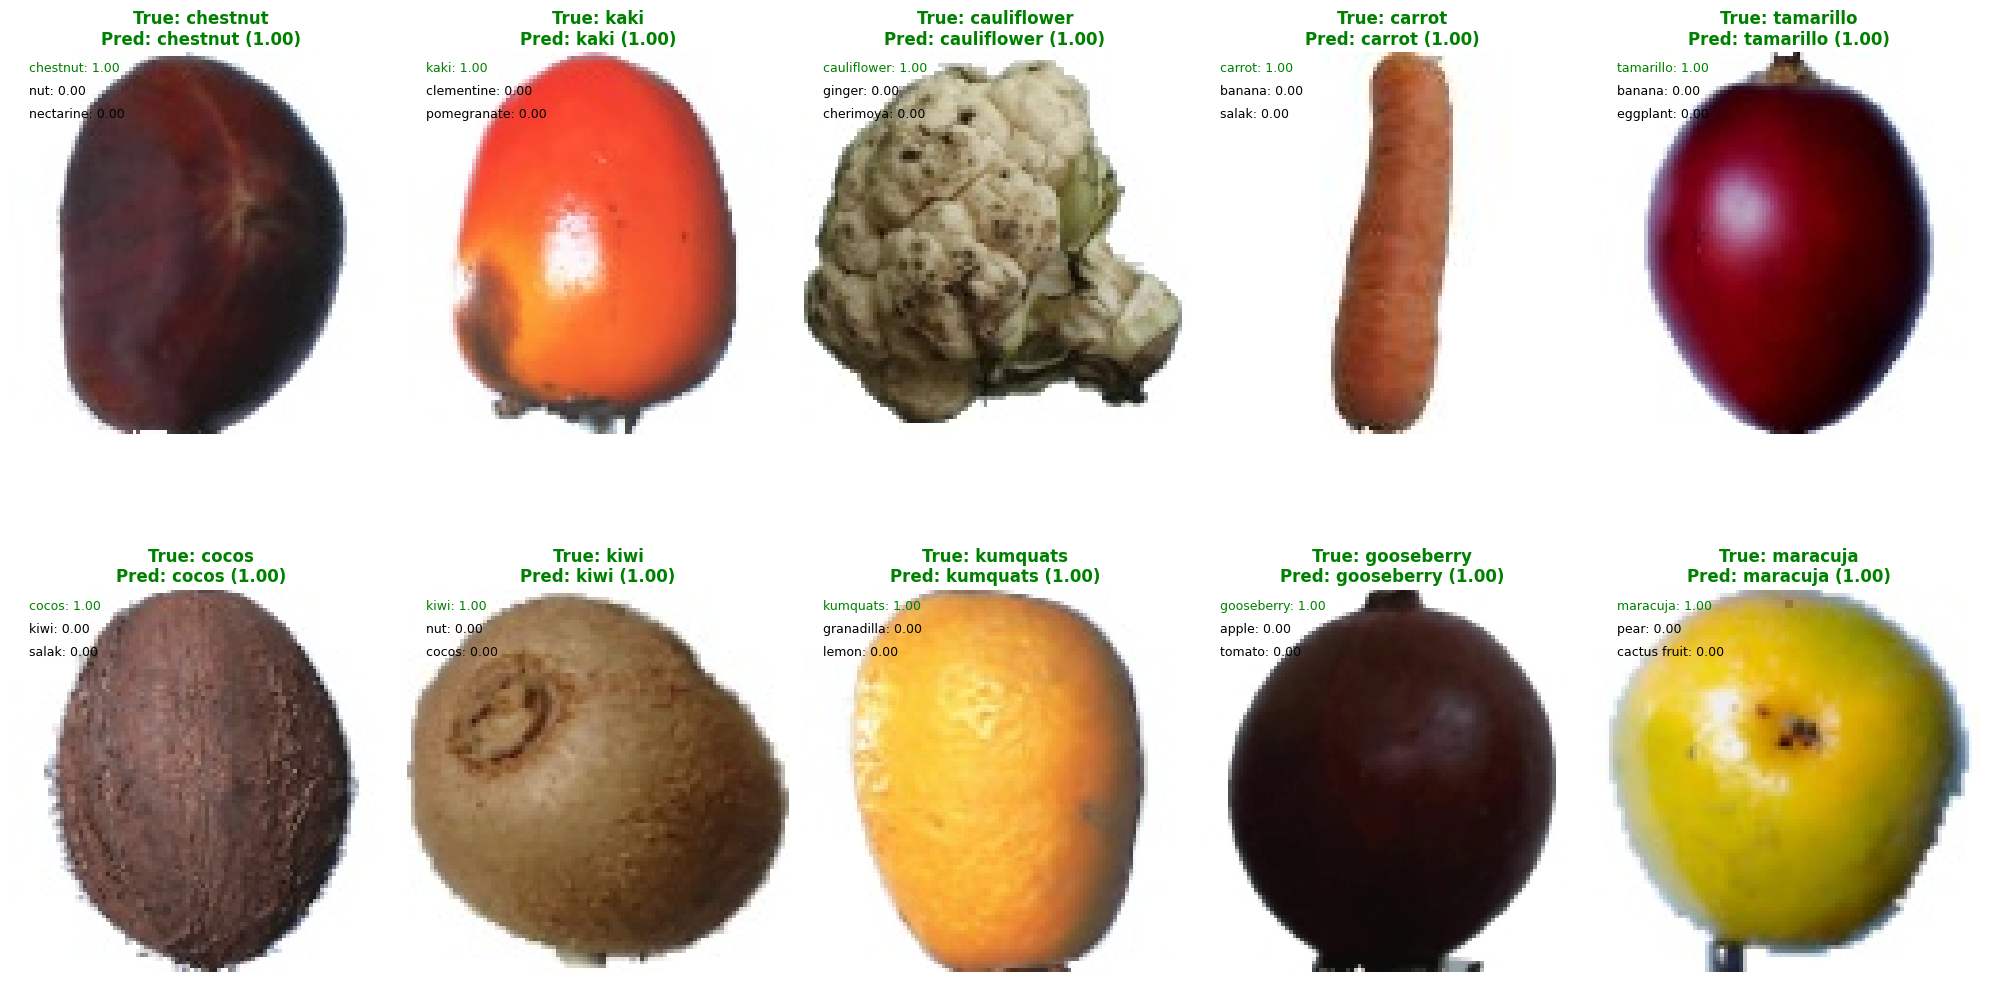

In [7]:
# Test the model on some random images from the validation set
# In our new structure, we need to find images from class directories

# Get a list of sample images from each class
test_samples = []
for cls_idx, cls_name in enumerate(class_names):
    val_class_dir = os.path.join(val_dir, cls_name)
    if not os.path.exists(val_class_dir):
        continue
        
    class_images = [f for f in os.listdir(val_class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    if class_images:
        # Take up to 2 images from each class to get a diverse sample
        for img_file in random.sample(class_images, min(2, len(class_images))):
            test_samples.append((cls_idx, cls_name, os.path.join(val_class_dir, img_file)))

# If we have too many samples, take a subset
if len(test_samples) > 10:
    test_samples = random.sample(test_samples, 10)

plt.figure(figsize=(20, 12))
for i, (true_class_idx, true_class, img_path) in enumerate(test_samples):
    if i >= 10:  # Limit to 10 images
        break
        
    # Make prediction
    results = trained_model(img_path)
    
    # Get top prediction
    probs = results[0].probs.data.tolist()
    pred_class_idx = probs.index(max(probs))
    pred_class = class_names[pred_class_idx]
    confidence = probs[pred_class_idx]
    
    # Get top 3 predictions for display
    top3_indices = sorted(range(len(probs)), key=lambda i: probs[i], reverse=True)[:3]
    top3_classes = [(class_names[idx], probs[idx]) for idx in top3_indices]
    
    # Display image with prediction
    plt.subplot(2, 5, i+1)
    img = Image.open(img_path)
    plt.imshow(img)
    
    # Color title based on prediction correctness
    title_color = 'green' if pred_class == true_class else 'red'
    plt.title(f"True: {true_class}\nPred: {pred_class} ({confidence:.2f})", 
              color=title_color, fontweight='bold')
    
    # Display top 3 predictions as text
    y_pos = 0.95
    for cls, prob in top3_classes:
        text_color = 'green' if cls == true_class else 'black'
        plt.text(0.05, y_pos, f"{cls}: {prob:.2f}", 
                 transform=plt.gca().transAxes, color=text_color, fontsize=9)
        y_pos -= 0.06
    
    plt.axis('off')

plt.tight_layout()
plt.show()

## 5. Confusion Matrix

Let's generate a confusion matrix to better understand the model's performance across different classes.

Predicting:   0%|          | 0/1520 [00:00<?, ?it/s]


image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_yolo/val/apple/Apple 8_r0_274_100.jpg: 224x224 apple 1.00, tomato 0.00, nectarine 0.00, gooseberry 0.00, pear 0.00, 3.3ms
Speed: 1.3ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_yolo/val/apple/Apple Core 1_r0_133_100.jpg: 224x224 apple 1.00, pear 0.00, tomato 0.00, blackberrie 0.00, strawberry 0.00, 3.9ms
Speed: 1.3ms preprocess, 3.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_yolo/val/apple/Apple worm 1_r2_35_100.jpg: 224x224 apple 1.00, tomato 0.00, nectarine 0.00, fig 0.00, mango 0.00, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_yolo/val/apple/Apple hit 

<Figure size 1500x1500 with 0 Axes>

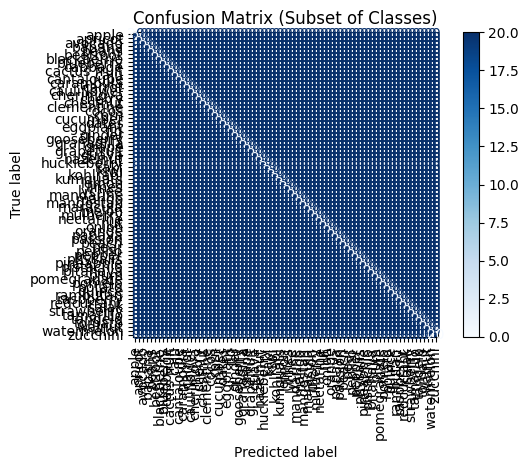

Classification Report:


,precision,recall,f1-score,support
apple,1.0,1.0,1.0,20.0
apricot,1.0,1.0,1.0,20.0
avocado,1.0,1.0,1.0,20.0
banana,1.0,1.0,1.0,20.0
beans,1.0,1.0,1.0,20.0
...,...,...,...,...
watermelon,1.0,1.0,1.0,20.0
zucchini,1.0,1.0,1.0,20.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1520.0


In [8]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def predict_batch(model, image_data, class_names):
    """
    Run predictions on a batch of images and return true and predicted labels
    
    Args:
        model: YOLO model
        image_data: List of tuples (class_idx, class_name, image_path)
        class_names: List of all class names
    
    Returns:
        true_labels, pred_labels
    """
    true_labels = []
    pred_labels = []
    
    for class_idx, _, img_path in tqdm(image_data, desc="Predicting"):
        # True label is already known from the directory structure
        true_labels.append(class_idx)
        
        # Get prediction
        results = model(img_path)
        probs = results[0].probs.data.tolist()
        pred_idx = probs.index(max(probs))
        
        pred_labels.append(pred_idx)
    
    return true_labels, pred_labels

# Collect test samples from validation set
test_data = []
for cls_idx, cls_name in enumerate(class_names):
    val_class_dir = os.path.join(val_dir, cls_name)
    if not os.path.exists(val_class_dir):
        continue
        
    class_images = [f for f in os.listdir(val_class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    # Take up to 20 images per class (to keep the confusion matrix computation reasonable)
    sample_count = min(20, len(class_images))
    if sample_count > 0:
        for img_file in random.sample(class_images, sample_count):
            test_data.append((cls_idx, cls_name, os.path.join(val_class_dir, img_file)))

# Run predictions
true_labels, pred_labels = predict_batch(trained_model, test_data, class_names)

# Find unique classes in the subset
unique_true_classes = sorted(set(true_labels))
unique_pred_classes = sorted(set(pred_labels))
unique_classes = sorted(set(unique_true_classes + unique_pred_classes))

# Generate confusion matrix for only the classes that appear in our sample
cm = confusion_matrix(true_labels, pred_labels, labels=unique_classes)

# Create display labels for only those classes present in our sample
display_labels = [class_names[i] for i in unique_classes]

# Plot confusion matrix
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Confusion Matrix (Subset of Classes)')
plt.tight_layout()
plt.show()

# Calculate per-class metrics
from sklearn.metrics import classification_report

# Create a target_names list that includes only the classes present in our sample
target_names = [class_names[i] for i in unique_classes]

report = classification_report(true_labels, pred_labels, labels=unique_classes, 
                              target_names=target_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
display(report_df)

## 6. Export and Save the Model

Let's export our trained model for deployment.

In [11]:
export_dir = os.path.join("..", "models", "fruits_classifier")

In [ ]:
# Export the model to ONNX format for deployment
os.makedirs(export_dir, exist_ok=True)

# Copy the best PyTorch model
shutil.copy(best_model_path, os.path.join(export_dir, "best.pt"))

# Export to ONNX format
onnx_path = os.path.join(export_dir, "model.onnx")
try:
    trained_model.export(format="onnx", imgsz=IMG_SIZE)
    print(f"Model exported to ONNX format: {onnx_path}")
except Exception as e:
    print(f"ONNX export failed: {e}")

# Save class names for inference
with open(os.path.join(export_dir, "classes.txt"), "w") as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

print(f"Model and class names saved to {export_dir}")
print("You can now use this model for inference on new images!")

Ultralytics 8.3.158 🚀 Python-3.13.3 torch-2.7.1+cu126 CPU (AMD Ryzen 7 7735HS with Radeon Graphics)

PyTorch: starting from '../runs/fruits_classification/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 76) (3.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

PyTorch: starting from '../runs/fruits_classification/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 76) (3.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
WARNING ⚠️ Retry 1/2 failed: Command 'uv pip install --no-cache-dir "onnx>=1.12.0,<1.18.0" "onnxruntime-gpu"  --index-strategy=unsafe-best-match --break-system-packages --prerelease=allow' returned non-zero exit status 1.
WARNING ⚠️ Retry 1/2 failed: Command 'uv pip install --no-cache-dir "onnx>=1.12.0,<1.18.0" "onnxruntime-gpu"  --index-strategy=unsafe-best-match

## 7. Example Inference Code

Here's an example of how to use the trained model for inference on new images.

In [9]:
def classify_fruit(model_path, image_path, class_names):
    """
    Classify a fruit image using the trained model
    
    Args:
        model_path: Path to the trained model
        image_path: Path to the image to classify
        class_names: List of class names
    
    Returns:
        Predicted class name and confidence
    """
    # Load the model
    model = YOLO(model_path)
    
    # Run inference
    results = model(image_path)
    
    # Get top prediction
    probs = results[0].probs.data.tolist()
    pred_class_idx = probs.index(max(probs))
    pred_class = class_names[pred_class_idx]
    confidence = probs[pred_class_idx]
    
    # Get top 3 predictions
    top3_indices = sorted(range(len(probs)), key=lambda i: probs[i], reverse=True)[:3]
    top3_classes = [(class_names[idx], probs[idx]) for idx in top3_indices]
    
    return pred_class, confidence, top3_classes

# Example usage:
# To test this function, you would use:
# pred_class, confidence, top3 = classify_fruit(
#     model_path=os.path.join(export_dir, "best.pt"),
#     image_path="/path/to/your/test/image.jpg",
#     class_names=class_names
# )
# print(f"Predicted class: {pred_class} with confidence {confidence:.2f}")
# print("Top 3 predictions:")
# for cls, prob in top3:
#     print(f"  {cls}: {prob:.2f}")


image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fridge_testing/onion2.png: 224x224 cucumber 0.67, pear 0.25, potato 0.05, beetroot 0.01, nut 0.00, 3.4ms
Speed: 14.4ms preprocess, 3.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


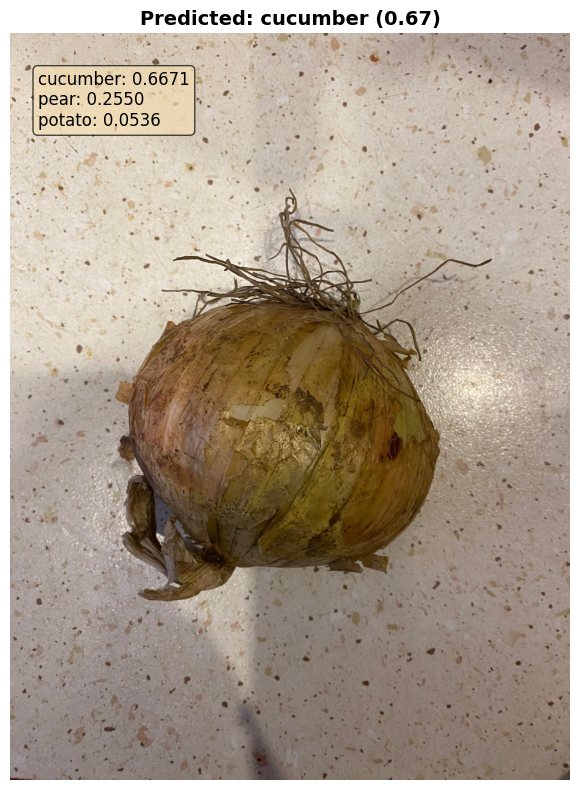

Predicted class: cucumber with confidence 0.6671
Top 3 predictions:
  cucumber: 0.6671
  pear: 0.2550
  potato: 0.0536


In [18]:
# Create a function to display an image with predictions
def display_prediction(model_path, image_path, class_names):
    """
    Classify and display an image with prediction results
    
    Args:
        model_path: Path to the trained model
        image_path: Path to the image to classify
        class_names: List of class names
    """
    # Load the image
    img = Image.open(image_path)
    
    # Make prediction
    pred_class, confidence, top3_classes = classify_fruit(
        model_path=model_path,
        image_path=image_path,
        class_names=class_names
    )
    
    # Create figure
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class} ({confidence:.2f})", fontsize=14, fontweight='bold')
    
    # Display top 3 predictions as text box
    textstr = "\n".join([f"{cls}: {prob:.4f}" for cls, prob in top3_classes])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return pred_class, confidence, top3_classes

# Use the function to display the prediction for the test image
pred_class, confidence, top3 = display_prediction(
    model_path=os.path.join(export_dir, "best.pt"),
    image_path=os.path.join("..", "datasets", "fridge_testing", "onion2.png"),
    class_names=class_names
)

# Print additional information
print(f"Predicted class: {pred_class} with confidence {confidence:.4f}")
print("Top 3 predictions:")
for cls, prob in top3:
    print(f"  {cls}: {prob:.4f}")